In [3]:
import sys
!{sys.executable} -m pip install numpy==1.26.4
pip install matplotlib
pip install scikit-learn
pip install transformers
pip install torch
pip install pandas
pip install huggingface_hub[hf_xet]
pip install nltk
pip install --upgrade nltk


In [10]:
!python -c "import nltk; nltk.download('punkt'); nltk.download('punkt_tab')"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\unitf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\unitf\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [3]:
#TRAIN CUBAA
import sys
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from data_processing import dataset_ATM, dataset_ABSA
from bert_ate_absa_models import bert_ATE, bert_ABSA
import torch
from transformers import logging

# Suppress warnings
logging.set_verbosity_error()

# Initialize device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\n=========================== DEVICE INFO ===========================")

if DEVICE.type == "cuda":
    print(f"GPU detected and in use: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU. Consider enabling a GPU for faster performance.")

print("==================================================================\n")


pretrain_model_name = "bert-base-uncased"  # Changed to base model
tokenizer = BertTokenizer.from_pretrained(pretrain_model_name)

# Initialize models
# Load model on CPU first, then move to GPU
ate_model = bert_ATE.from_pretrained(pretrain_model_name, num_labels=3)
absa_model = bert_ABSA.from_pretrained(pretrain_model_name, num_labels=3)

ate_model.to(DEVICE)
absa_model.to(DEVICE)

# Optimizers
lr = 2e-5
optimizer_ATE = AdamW(ate_model.parameters(), lr=lr, weight_decay=1e-4)
optimizer_ABSA = AdamW(absa_model.parameters(), lr=lr, weight_decay=1e-4)

# Helper functions
def evl_time(t):
    min, sec = divmod(t, 60)
    hr, min = divmod(min, 60)
    return int(hr), int(min), int(sec)

# Save and Load Models as .pkl
def save_model_pkl(model, path):
    torch.save(model.state_dict(), path)

def load_model_pkl(model, path):
    model.load_state_dict(torch.load(path))
    return model

# ATE: Create mini-batches
def create_mini_batch(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    tags_tensors = [s[2] for s in samples]
    tags_tensors = pad_sequence(tags_tensors, batch_first=True)

    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

    return ids_tensors, tags_tensors, masks_tensors

# ATE: Train Model with Debugging
def train_ate(loader, model, optimizer, epochs):
    model.train()
    print("Starting ATE Training...")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}...")
        epoch_loss = 0
        batch_count = 0
        for ids_tensors, tags_tensors, masks_tensors in loader:
            batch_count += 1
            ids_tensors, tags_tensors, masks_tensors = (
                ids_tensors.to(DEVICE),
                tags_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
            )
            optimizer.zero_grad()
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors, labels=tags_tensors)
            loss = outputs["loss"]
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Print progress every 10 batches
            if batch_count % 10 == 0:
                print(f"  Batch {batch_count}/{len(loader)} - Loss: {loss.item():.4f}")

        print(f"Epoch {epoch + 1} completed. Average Loss: {epoch_loss / len(loader):.4f}")
    print("ATE Training Completed.")

# ATE: Test Model with Flattened Output
def test_ate(loader, model):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for ids_tensors, tags_tensors, masks_tensors in loader:
            ids_tensors, tags_tensors, masks_tensors = (
                ids_tensors.to(DEVICE),
                tags_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors)
            logits = outputs["logits"]
            _, preds = torch.max(logits, dim=2)

            # Flatten the batch outputs
            for pred, truth in zip(preds, tags_tensors):
                predictions.extend(pred.cpu().tolist())
                truths.extend(truth.cpu().tolist())

    return truths, predictions

# ABSA: Create mini-batches
def create_mini_batch_absa(samples):
    max_len = max([len(s[1]) for s in samples])
    ids_tensors = [torch.cat([s[1], torch.zeros(max_len - len(s[1]), dtype=torch.long)]) for s in samples]
    ids_tensors = torch.stack(ids_tensors)
    segments_tensors = [torch.cat([s[2], torch.zeros(max_len - len(s[2]), dtype=torch.long)]) for s in samples]
    segments_tensors = torch.stack(segments_tensors)
    label_ids = torch.stack([s[3] for s in samples])
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)
    return ids_tensors, segments_tensors, masks_tensors, label_ids

# ABSA: Train Model with Debugging and Dynamic Batch Adjustment
def train_absa(loader, val_loader, model, optimizer, epochs):
    print("Starting ABSA Training...")
    total_steps = len(loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)
    best_val_loss = float("inf")

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}...")
        model.train()
        total_loss = 0
        batch_count = 0

        for ids_tensors, segments_tensors, masks_tensors, label_ids in loader:
            try:
                batch_count += 1
                ids_tensors, segments_tensors, masks_tensors, label_ids = (
                    ids_tensors.to(DEVICE),
                    segments_tensors.to(DEVICE),
                    masks_tensors.to(DEVICE),
                    label_ids.to(DEVICE),
                )
                optimizer.zero_grad()
                outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors, token_type_ids=segments_tensors, labels=label_ids)
                loss = outputs["loss"]
                loss.backward()
                optimizer.step()
                scheduler.step()
                total_loss += loss.item()

                # Print progress every 10 batches
                if batch_count % 10 == 0:
                    print(f"  Batch {batch_count}/{len(loader)} - Loss: {loss.item():.4f}")

            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print("  [WARNING] CUDA out of memory. Skipping batch.")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")

        # Validation
        print("  Validating...")
        val_loss = validate_absa(val_loader, model)
        print(f"  Validation Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model_pkl(model, "absa_model_v1.pkl")
            print("  Model saved with improved validation loss.")
    print("ABSA Training Completed.")

# ABSA: Validate Model
def validate_absa(loader, model):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for ids_tensors, segments_tensors, masks_tensors, label_ids in loader:
            ids_tensors, segments_tensors, masks_tensors, label_ids = (
                ids_tensors.to(DEVICE),
                segments_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
                label_ids.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors, token_type_ids=segments_tensors, labels=label_ids)
            loss = outputs["loss"]
            total_loss += loss.item()
    return total_loss / len(loader)

# ABSA: Test Model
def test_absa(loader, model):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for ids_tensors, segments_tensors, masks_tensors, label_ids in loader:
            ids_tensors, segments_tensors, masks_tensors, label_ids = (
                ids_tensors.to(DEVICE),
                segments_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
                label_ids.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors, token_type_ids=segments_tensors)
            logits = outputs["logits"]
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            truths.extend(label_ids.cpu().tolist())
    return truths, predictions

# ATE Data
ate_train_ds = dataset_ATM(pd.read_csv("mrt_train.csv"), tokenizer)
ate_test_ds = dataset_ATM(pd.read_csv("mrt_test.csv"), tokenizer)
ate_train_loader = DataLoader(ate_train_ds, batch_size=8, collate_fn=create_mini_batch, shuffle=True)
ate_test_loader = DataLoader(ate_test_ds, batch_size=8, collate_fn=create_mini_batch, shuffle=False)

# ABSA Data
absa_train_ds = dataset_ABSA(pd.read_csv("mrt_train.csv"), tokenizer)
absa_val_ds = dataset_ABSA(pd.read_csv("mrt_val.csv"), tokenizer)
absa_test_ds = dataset_ABSA(pd.read_csv("mrt_test.csv"), tokenizer)
absa_train_loader = DataLoader(absa_train_ds, batch_size=16, collate_fn=create_mini_batch_absa, shuffle=True)
absa_val_loader = DataLoader(absa_val_ds, batch_size=16, collate_fn=create_mini_batch_absa, shuffle=False)
absa_test_loader = DataLoader(absa_test_ds, batch_size=16, collate_fn=create_mini_batch_absa, shuffle=False)


#PROMPT USER FOR TRAINING MODE
if __name__ == "__main__":

    train_mode = input(
        "================================================================\n"
        "Select training mode:\n"
        "1) ATE Only\n"
        "2) ABSA Only\n"
        "3) Both ATE and ABSA models\n"
        "Enter choice (1, 2, or 3 (or type 'q' to quit)): "
    ).strip()

    # TRAIN/TEST ATE IF CHOSEN
    if train_mode in ["1", "3"]:
        print("\nModel will be saved to project directory as ate_model_v1.pkl")
        print("\nStarting to train ATE model...")
        train_ate(ate_train_loader, ate_model, optimizer_ATE, epochs=5)
        save_model_pkl(ate_model, "ate_model_v1.pkl")

        print("\nStarting to test ATE model...")
        truths, predictions = test_ate(ate_test_loader, ate_model)
        print("True labels:", set(truths))
        print("Predicted labels:", set(predictions))
        print(classification_report(truths, predictions, target_names=["Non-Aspect", "B-Term", "I-Term"]))

    # TRAIN/TEST ABSA IF CHOSEN
    if train_mode in ["2", "3"]:
        print("\nModel will be saved to project directory as absa_model_v1.pkl")
        print("\nStarting to train ABSA model...")
        train_absa(absa_train_loader, absa_val_loader, absa_model, optimizer_ABSA, epochs=8)

        print("\nStarting to test ABSA model...")
        truths, predictions = test_absa(absa_test_loader, absa_model)
        print("True labels:", set(truths))
        print("Predicted labels:", set(predictions))
        print(classification_report(
        truths,
         predictions,
    labels=[0, 1, 2],
    target_names=["Negative", "Neutral", "Positive"]
))


    if train_mode.lower() in ["q", "quit"]:
        print("\nExiting...\n")
        sys.exit(0)


=========================== DEVICE INFO ===========================
GPU detected and in use: NVIDIA GeForce GTX 1650



Select training mode:
1) ATE Only
2) ABSA Only
3) Both ATE and ABSA models
Enter choice (1, 2, or 3 (or type 'q' to quit)):  1



Model will be saved to project directory as ate_model_v1.pkl

Starting to train ATE model...
Starting ATE Training...
Epoch 1/5...
  Batch 10/223 - Loss: 0.6723
  Batch 20/223 - Loss: 0.7826
  Batch 30/223 - Loss: 0.7012
  Batch 40/223 - Loss: 0.8429
  Batch 50/223 - Loss: 0.6393
  Batch 60/223 - Loss: 0.6803
  Batch 70/223 - Loss: 0.6521
  Batch 80/223 - Loss: 0.5064
  Batch 90/223 - Loss: 0.5495
  Batch 100/223 - Loss: 0.3538
  Batch 110/223 - Loss: 0.4656
  Batch 120/223 - Loss: 0.3510
  Batch 130/223 - Loss: 0.1603
  Batch 140/223 - Loss: 0.1444
  Batch 150/223 - Loss: 0.4826
  Batch 160/223 - Loss: 0.2810
  Batch 170/223 - Loss: 0.3125
  Batch 180/223 - Loss: 0.2373
  Batch 190/223 - Loss: 0.3672
  Batch 200/223 - Loss: 0.1351
  Batch 210/223 - Loss: 0.0837
  Batch 220/223 - Loss: 0.1682
Epoch 1 completed. Average Loss: 0.4548
Epoch 2/5...
  Batch 10/223 - Loss: 0.1636
  Batch 20/223 - Loss: 0.1204
  Batch 30/223 - Loss: 0.1818
  Batch 40/223 - Loss: 0.1873
  Batch 50/223 - Loss:

In [1]:
#train cuba 3
import sys
import os
import pandas as pd
from torch.nn import CrossEntropyLoss
import numpy as np
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from data_processing import dataset_ATM, dataset_ABSA
from bert_ate_absa_models import bert_ATE, bert_ABSA
import torch
from transformers import logging

# Suppress warnings
logging.set_verbosity_error()

# Initialize device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\n=========================== DEVICE INFO ===========================")

if DEVICE.type == "cuda":
    print(f"GPU detected and in use: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU. Consider enabling a GPU for faster performance.")

print("==================================================================\n")


pretrain_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(pretrain_model_name)

# Initialize models
ate_model = bert_ATE.from_pretrained(pretrain_model_name, num_labels=3)
absa_model = bert_ABSA.from_pretrained(pretrain_model_name, num_labels=3)

ate_model.to(DEVICE)
absa_model.to(DEVICE)

# Optimizers
lr = 2e-5
optimizer_ATE = AdamW(ate_model.parameters(), lr=lr, weight_decay=1e-4)
optimizer_ABSA = AdamW(absa_model.parameters(), lr=lr, weight_decay=1e-4)

# Helper functions
def evl_time(t):
    min, sec = divmod(t, 60)
    hr, min = divmod(min, 60)
    return int(hr), int(min), int(sec)

# Save and Load Models as .pkl
def save_model_pkl(model, path):
    torch.save(model.state_dict(), path)

def load_model_pkl(model, path):
    model.load_state_dict(torch.load(path))
    return model

# ATE: Create mini-batches (still needed for ATE)
def create_mini_batch(samples):
    # samples are (bert_tokens, ids_tensor, tags_tensor, pols_tensor) from dataset_ATM
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    tags_tensors = [s[2] for s in samples]
    tags_tensors = pad_sequence(tags_tensors, batch_first=True)

    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

    # This function returns 3 tensors
    return ids_tensors, tags_tensors, masks_tensors

# ATE: Train Model with Debugging
def train_ate(loader, model, optimizer, epochs):
    model.train()
    print("Starting ATE Training...")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}...")
        epoch_loss = 0
        batch_count = 0
        # FIX: Removed '_' for pols_tensor. Now correctly unpacks 3 items.
        for ids_tensors, tags_tensors, masks_tensors in loader:
            batch_count += 1
            ids_tensors, tags_tensors, masks_tensors = (
                ids_tensors.to(DEVICE),
                tags_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
            )
            optimizer.zero_grad()
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors, labels=tags_tensors)
            loss = outputs["loss"]
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Print progress every 10 batches
            if batch_count % 10 == 0:
                print(f"  Batch {batch_count}/{len(loader)} - Loss: {loss.item():.4f}")

        print(f"Epoch {epoch + 1} completed. Average Loss: {epoch_loss / len(loader):.4f}")
    print("ATE Training Completed.")

# ATE: Test Model with Flattened Output
def test_ate(loader, model):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        # FIX: Removed '_' for pols_tensor. Now correctly unpacks 3 items.
        for ids_tensors, tags_tensors, masks_tensors in loader:
            ids_tensors, tags_tensors, masks_tensors = (
                ids_tensors.to(DEVICE),
                tags_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors)
            logits = outputs["logits"]
            _, preds = torch.max(logits, dim=2)

            # Flatten the batch outputs
            for pred, truth in zip(preds, tags_tensors):
                predictions.extend(pred.cpu().tolist())
                truths.extend(truth.cpu().tolist())

    return truths, predictions

# ABSA: Train Model with Debugging and Dynamic Batch Adjustment
def train_absa(loader, val_loader, model, optimizer, epochs):
    print("Starting ABSA Training...")
    total_steps = len(loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=int(0.1 * total_steps), 
        num_training_steps=total_steps
    )
    best_val_loss = float("inf")

    # Define class weights: [Negative, Neutral, Positive]
    # Ensure these weights are appropriate for your class distribution
    class_weights = torch.tensor([4.0, 2.0, 1.0]).to(DEVICE) # Tune as needed
    loss_fct = CrossEntropyLoss(weight=class_weights)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}...")
        model.train()
        total_loss = 0
        batch_count = 0

        # ABSA DataLoader now yields input_ids, token_type_ids, attention_mask, sentiment_tensor
        for input_ids, token_type_ids, attention_mask, sentiment_tensor in loader:
            try:
                batch_count += 1
                input_ids, token_type_ids, attention_mask, sentiment_tensor = (
                    input_ids.to(DEVICE),
                    token_type_ids.to(DEVICE),
                    attention_mask.to(DEVICE),
                    sentiment_tensor.to(DEVICE),
                )

                optimizer.zero_grad()

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids # Pass token_type_ids
                )
                logits = outputs["logits"]
                loss = loss_fct(logits, sentiment_tensor) # Use sentiment_tensor as labels

                loss.backward()
                optimizer.step()
                scheduler.step()
                total_loss += loss.item()

                if batch_count % 10 == 0:
                    print(f"  Batch {batch_count}/{len(loader)} - Loss: {loss.item():.4f}")

            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print("  [WARNING] CUDA out of memory. Skipping batch.")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")

        # Validation
        print("  Validating...")
        val_loss = validate_absa(val_loader, model)
        print(f"  Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model_pkl(model, "absa_model_v1.pkl")
            print("  ✅ Model saved with improved validation loss.")

    print("ABSA Training Completed.")


# ABSA: Validate Model
def validate_absa(loader, model):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        # ABSA DataLoader now yields input_ids, token_type_ids, attention_mask, sentiment_tensor
        for input_ids, token_type_ids, attention_mask, sentiment_tensor in loader:
            input_ids, token_type_ids, attention_mask, sentiment_tensor = (
                input_ids.to(DEVICE),
                token_type_ids.to(DEVICE),
                attention_mask.to(DEVICE),
                sentiment_tensor.to(DEVICE),
            )
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=sentiment_tensor)
            loss = outputs["loss"]
            total_loss += loss.item()
    return total_loss / len(loader)

# ABSA: Test Model
def test_absa(loader, model):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        # ABSA DataLoader now yields input_ids, token_type_ids, attention_mask, sentiment_tensor
        for input_ids, token_type_ids, attention_mask, sentiment_tensor in loader:
            input_ids, token_type_ids, attention_mask, sentiment_tensor = (
                input_ids.to(DEVICE),
                token_type_ids.to(DEVICE),
                attention_mask.to(DEVICE),
                sentiment_tensor.to(DEVICE),
            )
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = outputs["logits"]
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            truths.extend(sentiment_tensor.cpu().tolist()) # Use sentiment_tensor for truths
    return truths, predictions

# ATE Data
ate_train_ds = dataset_ATM(pd.read_csv("mrt_train.csv"), tokenizer)
ate_test_ds = dataset_ATM(pd.read_csv("mrt_test.csv"), tokenizer)
ate_train_loader = DataLoader(ate_train_ds, batch_size=8, collate_fn=create_mini_batch, shuffle=True)
ate_test_loader = DataLoader(ate_test_ds, batch_size=8, collate_fn=create_mini_batch, shuffle=False)

# ABSA Data - NO collate_fn needed here as dataset_ABSA handles it
absa_train_ds = dataset_ABSA(pd.read_csv("mrt_train.csv"), tokenizer)
absa_val_ds = dataset_ABSA(pd.read_csv("mrt_val.csv"), tokenizer)
absa_test_ds = dataset_ABSA(pd.read_csv("mrt_test.csv"), tokenizer)
absa_train_loader = DataLoader(absa_train_ds, batch_size=16, shuffle=True) # Removed collate_fn
absa_val_loader = DataLoader(absa_val_ds, batch_size=16, shuffle=False) # Removed collate_fn
absa_test_loader = DataLoader(absa_test_ds, batch_size=16, shuffle=False) # Removed collate_fn


#PROMPT USER FOR TRAINING MODE
if __name__ == "__main__":

    train_mode = input(
        "================================================================\n"
        "Select training mode:\n"
        "1) ATE Only\n"
        "2) ABSA Only\n"
        "3) Both ATE and ABSA models\n"
        "Enter choice (1, 2, or 3 (or type 'q' to quit)): "
    ).strip()

    # TRAIN/TEST ATE IF CHOSEN
    if train_mode in ["1", "3"]:
        print("\nModel will be saved to project directory as ate_model_v1.pkl")
        print("\nStarting to train ATE model...")
        train_ate(ate_train_loader, ate_model, optimizer_ATE, epochs=5)
        save_model_pkl(ate_model, "ate_model_v1.pkl")

        print("\nStarting to test ATE model...")
        truths, predictions = test_ate(ate_test_loader, ate_model)
        print("True labels:", set(truths))
        print("Predicted labels:", set(predictions))
        print(classification_report(truths, predictions, target_names=["Non-Aspect", "B-Term", "I-Term"]))

    # TRAIN/TEST ABSA IF CHOSEN
    if train_mode in ["2", "3"]:
        print("\nModel will be saved to project directory as absa_model_v1.pkl")
        print("\nStarting to train ABSA model...")
        train_absa(absa_train_loader, absa_val_loader, absa_model, optimizer_ABSA, epochs=8)

        print("\nStarting to test ABSA model...")
        truths, predictions = test_absa(absa_test_loader, absa_model)
        print("True labels:", set(truths))
        print("Predicted labels:", set(predictions))
        print(classification_report(
            truths,
            predictions,
            labels=[0, 1, 2],
            target_names=["Negative", "Neutral", "Positive"]
        ))

    if train_mode.lower() in ["q", "quit"]:
        print("\nExiting...\n")
        sys.exit(0)



=========================== DEVICE INFO ===========================
GPU detected and in use: NVIDIA GeForce GTX 1650



Select training mode:
1) ATE Only
2) ABSA Only
3) Both ATE and ABSA models
Enter choice (1, 2, or 3 (or type 'q' to quit)):  2



Model will be saved to project directory as absa_model_v1.pkl

Starting to train ABSA model...
Starting ABSA Training...
Epoch 1/8...
  Batch 10/117 - Loss: 1.3091
  Batch 20/117 - Loss: 1.1544
  Batch 30/117 - Loss: 1.0222
  Batch 40/117 - Loss: 1.0003
  Batch 50/117 - Loss: 1.2221
  Batch 60/117 - Loss: 0.6898
  Batch 70/117 - Loss: 0.7424
  Batch 80/117 - Loss: 1.2912
  Batch 90/117 - Loss: 0.7239
  Batch 100/117 - Loss: 1.2577
  Batch 110/117 - Loss: 0.5313
Epoch 1 completed. Average Loss: 0.8890
  Validating...
  Validation Loss: 0.5952
  ✅ Model saved with improved validation loss.
Epoch 2/8...
  Batch 10/117 - Loss: 0.2176
  Batch 20/117 - Loss: 0.1738
  Batch 30/117 - Loss: 0.1541
  Batch 40/117 - Loss: 0.4173
  Batch 50/117 - Loss: 0.1398
  Batch 60/117 - Loss: 0.3729
  Batch 70/117 - Loss: 0.1921
  Batch 80/117 - Loss: 0.1465
  Batch 90/117 - Loss: 0.1137
  Batch 100/117 - Loss: 0.0622
  Batch 110/117 - Loss: 0.5161
Epoch 2 completed. Average Loss: 0.2546
  Validating...
  V

In [1]:
#TRAIN CUBAA 2
import sys
import os
import pandas as pd
from torch.nn import CrossEntropyLoss
import numpy as np
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from data_processing import dataset_ATM, dataset_ABSA
from bert_ate_absa_models import bert_ATE, bert_ABSA
import torch
from transformers import logging

# Suppress warnings
logging.set_verbosity_error()

# Initialize device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\n=========================== DEVICE INFO ===========================")

if DEVICE.type == "cuda":
    print(f"GPU detected and in use: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU. Consider enabling a GPU for faster performance.")

print("==================================================================\n")


pretrain_model_name = "bert-base-uncased"  # Changed to base model
tokenizer = BertTokenizer.from_pretrained(pretrain_model_name)

# Initialize models
# Load model on CPU first, then move to GPU
ate_model = bert_ATE.from_pretrained(pretrain_model_name, num_labels=3)
absa_model = bert_ABSA.from_pretrained(pretrain_model_name, num_labels=3)

ate_model.to(DEVICE)
absa_model.to(DEVICE)

# Optimizers
lr = 2e-5
optimizer_ATE = AdamW(ate_model.parameters(), lr=lr, weight_decay=1e-4)
optimizer_ABSA = AdamW(absa_model.parameters(), lr=lr, weight_decay=1e-4)

# Helper functions
def evl_time(t):
    min, sec = divmod(t, 60)
    hr, min = divmod(min, 60)
    return int(hr), int(min), int(sec)

# Save and Load Models as .pkl
def save_model_pkl(model, path):
    torch.save(model.state_dict(), path)

def load_model_pkl(model, path):
    model.load_state_dict(torch.load(path))
    return model

# ATE: Create mini-batches
def create_mini_batch(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    tags_tensors = [s[2] for s in samples]
    tags_tensors = pad_sequence(tags_tensors, batch_first=True)

    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

    return ids_tensors, tags_tensors, masks_tensors

# ATE: Train Model with Debugging
def train_ate(loader, model, optimizer, epochs):
    model.train()
    print("Starting ATE Training...")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}...")
        epoch_loss = 0
        batch_count = 0
        for ids_tensors, tags_tensors, masks_tensors in loader:
            batch_count += 1
            ids_tensors, tags_tensors, masks_tensors = (
                ids_tensors.to(DEVICE),
                tags_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
            )
            optimizer.zero_grad()
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors, labels=tags_tensors)
            loss = outputs["loss"]
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Print progress every 10 batches
            if batch_count % 10 == 0:
                print(f"  Batch {batch_count}/{len(loader)} - Loss: {loss.item():.4f}")

        print(f"Epoch {epoch + 1} completed. Average Loss: {epoch_loss / len(loader):.4f}")
    print("ATE Training Completed.")

# ATE: Test Model with Flattened Output
def test_ate(loader, model):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for ids_tensors, tags_tensors, masks_tensors in loader:
            ids_tensors, tags_tensors, masks_tensors = (
                ids_tensors.to(DEVICE),
                tags_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors)
            logits = outputs["logits"]
            _, preds = torch.max(logits, dim=2)

            # Flatten the batch outputs
            for pred, truth in zip(preds, tags_tensors):
                predictions.extend(pred.cpu().tolist())
                truths.extend(truth.cpu().tolist())

    return truths, predictions

# ABSA: Create mini-batches
def create_mini_batch_absa(samples):
    max_len = max([len(s[1]) for s in samples])
    ids_tensors = [torch.cat([s[1], torch.zeros(max_len - len(s[1]), dtype=torch.long)]) for s in samples]
    ids_tensors = torch.stack(ids_tensors)
    segments_tensors = [torch.cat([s[2], torch.zeros(max_len - len(s[2]), dtype=torch.long)]) for s in samples]
    segments_tensors = torch.stack(segments_tensors)
    label_ids = torch.stack([s[3] for s in samples])
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)
    return ids_tensors, segments_tensors, masks_tensors, label_ids

# ABSA: Train Model with Debugging and Dynamic Batch Adjustment
def train_absa(loader, val_loader, model, optimizer, epochs):
    print("Starting ABSA Training...")
    total_steps = len(loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=int(0.1 * total_steps), 
        num_training_steps=total_steps
    )
    best_val_loss = float("inf")

    # Define class weights: [Negative, Neutral, Positive]
    class_weights = torch.tensor([4.0, 2.0, 1.0]).to(DEVICE)  # Tune as needed
    loss_fct = CrossEntropyLoss(weight=class_weights)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}...")
        model.train()
        total_loss = 0
        batch_count = 0

        for ids_tensors, segments_tensors, masks_tensors, label_ids in loader:
            try:
                batch_count += 1
                ids_tensors, segments_tensors, masks_tensors, label_ids = (
                    ids_tensors.to(DEVICE),
                    segments_tensors.to(DEVICE),
                    masks_tensors.to(DEVICE),
                    label_ids.to(DEVICE),
                )

                optimizer.zero_grad()

                outputs = model(
                    input_ids=ids_tensors,
                    attention_mask=masks_tensors,
                    token_type_ids=segments_tensors
                )
                logits = outputs["logits"]
                loss = loss_fct(logits, label_ids)

                loss.backward()
                optimizer.step()
                scheduler.step()
                total_loss += loss.item()

                if batch_count % 10 == 0:
                    print(f"  Batch {batch_count}/{len(loader)} - Loss: {loss.item():.4f}")

            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print("  [WARNING] CUDA out of memory. Skipping batch.")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")

        # Validation
        print("  Validating...")
        val_loss = validate_absa(val_loader, model)
        print(f"  Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model_pkl(model, "absa_model_v1.pkl")
            print("  ✅ Model saved with improved validation loss.")

    print("ABSA Training Completed.")


# ABSA: Validate Model
def validate_absa(loader, model):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for ids_tensors, segments_tensors, masks_tensors, label_ids in loader:
            ids_tensors, segments_tensors, masks_tensors, label_ids = (
                ids_tensors.to(DEVICE),
                segments_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
                label_ids.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors, token_type_ids=segments_tensors, labels=label_ids)
            loss = outputs["loss"]
            total_loss += loss.item()
    return total_loss / len(loader)

# ABSA: Test Model
def test_absa(loader, model):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for ids_tensors, segments_tensors, masks_tensors, label_ids in loader:
            ids_tensors, segments_tensors, masks_tensors, label_ids = (
                ids_tensors.to(DEVICE),
                segments_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
                label_ids.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors, token_type_ids=segments_tensors)
            logits = outputs["logits"]
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            truths.extend(label_ids.cpu().tolist())
    return truths, predictions

# ATE Data
ate_train_ds = dataset_ATM(pd.read_csv("mrt_train.csv"), tokenizer)
ate_test_ds = dataset_ATM(pd.read_csv("mrt_test.csv"), tokenizer)
ate_train_loader = DataLoader(ate_train_ds, batch_size=8, collate_fn=create_mini_batch, shuffle=True)
ate_test_loader = DataLoader(ate_test_ds, batch_size=8, collate_fn=create_mini_batch, shuffle=False)

# ABSA Data
absa_train_ds = dataset_ABSA(pd.read_csv("mrt_train.csv"), tokenizer)
absa_val_ds = dataset_ABSA(pd.read_csv("mrt_val.csv"), tokenizer)
absa_test_ds = dataset_ABSA(pd.read_csv("mrt_test.csv"), tokenizer)
absa_train_loader = DataLoader(absa_train_ds, batch_size=16, collate_fn=create_mini_batch_absa, shuffle=True)
absa_val_loader = DataLoader(absa_val_ds, batch_size=16, collate_fn=create_mini_batch_absa, shuffle=False)
absa_test_loader = DataLoader(absa_test_ds, batch_size=16, collate_fn=create_mini_batch_absa, shuffle=False)


#PROMPT USER FOR TRAINING MODE
if __name__ == "__main__":

    train_mode = input(
        "================================================================\n"
        "Select training mode:\n"
        "1) ATE Only\n"
        "2) ABSA Only\n"
        "3) Both ATE and ABSA models\n"
        "Enter choice (1, 2, or 3 (or type 'q' to quit)): "
    ).strip()

    # TRAIN/TEST ATE IF CHOSEN
    if train_mode in ["1", "3"]:
        print("\nModel will be saved to project directory as ate_model_v1.pkl")
        print("\nStarting to train ATE model...")
        train_ate(ate_train_loader, ate_model, optimizer_ATE, epochs=5)
        save_model_pkl(ate_model, "ate_model_v1.pkl")

        print("\nStarting to test ATE model...")
        truths, predictions = test_ate(ate_test_loader, ate_model)
        print("True labels:", set(truths))
        print("Predicted labels:", set(predictions))
        print(classification_report(truths, predictions, target_names=["Non-Aspect", "B-Term", "I-Term"]))

    # TRAIN/TEST ABSA IF CHOSEN
    if train_mode in ["2", "3"]:
        print("\nModel will be saved to project directory as absa_model_v1.pkl")
        print("\nStarting to train ABSA model...")
        train_absa(absa_train_loader, absa_val_loader, absa_model, optimizer_ABSA, epochs=8)

        print("\nStarting to test ABSA model...")
        truths, predictions = test_absa(absa_test_loader, absa_model)
        print("True labels:", set(truths))
        print("Predicted labels:", set(predictions))
        print(classification_report(
        truths,
         predictions,
    labels=[0, 1, 2],
    target_names=["Negative", "Neutral", "Positive"]
))


    if train_mode.lower() in ["q", "quit"]:
        print("\nExiting...\n")
        sys.exit(0)


=========================== DEVICE INFO ===========================
GPU detected and in use: NVIDIA GeForce GTX 1650



KeyboardInterrupt: Interrupted by user

Using device: cuda:0

=== ATE Classification Report ===
True labels: {0, 1, 2}
Predicted labels: {0, 1, 2}
              precision    recall  f1-score   support

  Non-Aspect       0.97      0.96      0.96      2072
      B-Term       0.82      0.83      0.82       468
      I-Term       0.81      0.85      0.83       292

    accuracy                           0.93      2832
   macro avg       0.87      0.88      0.87      2832
weighted avg       0.93      0.93      0.93      2832



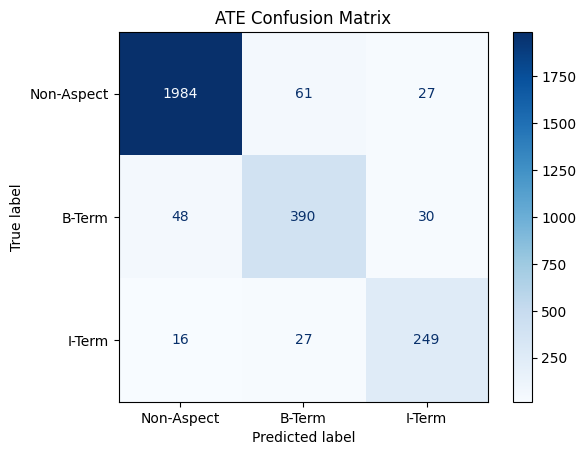


=== ABSA Classification Report ===
True labels: {0, 1, 2}
Predicted labels: {0, 1, 2}
              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98       148
     Neutral       0.79      0.77      0.78        43
    Positive       0.94      0.96      0.95       190

    accuracy                           0.94       381
   macro avg       0.91      0.90      0.90       381
weighted avg       0.94      0.94      0.94       381



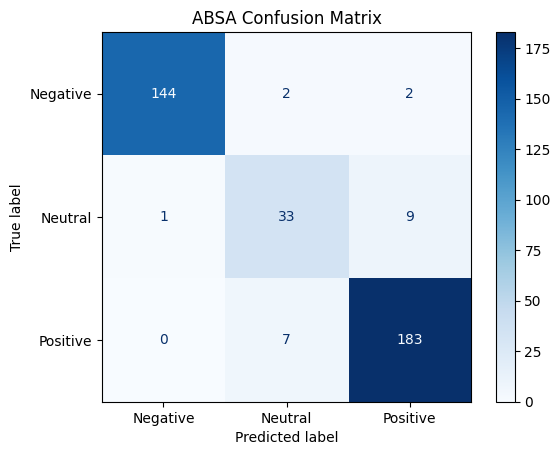

In [3]:
"""# test.py
import sys
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer

from bert_ate_absa_models import bert_ATE, bert_ABSA
from data_processing import dataset_ATM, dataset_ABSA

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


def load_model_pkl(model, path):
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    return model

def test_ate(loader, model):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for ids_tensors, tags_tensors, masks_tensors in loader:
            ids_tensors, tags_tensors, masks_tensors = (
                ids_tensors.to(DEVICE),
                tags_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors)
            logits = outputs["logits"]
            _, preds = torch.max(logits, dim=2)
            for pred, truth in zip(preds, tags_tensors):
                predictions.extend(pred.cpu().tolist())
                truths.extend(truth.cpu().tolist())
    return truths, predictions

def test_absa(loader, model):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for ids_tensors, segments_tensors, masks_tensors, label_ids in loader:
            ids_tensors, segments_tensors, masks_tensors, label_ids = (
                ids_tensors.to(DEVICE),
                segments_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
                label_ids.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors, token_type_ids=segments_tensors)
            logits = outputs["logits"]
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            truths.extend(label_ids.cpu().tolist())
    return truths, predictions

def create_mini_batch(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)
    tags_tensors = [s[2] for s in samples]
    tags_tensors = pad_sequence(tags_tensors, batch_first=True)
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)
    return ids_tensors, tags_tensors, masks_tensors

def create_mini_batch_absa(samples):
    max_len = max([len(s[1]) for s in samples])
    ids_tensors = [torch.cat([s[1], torch.zeros(max_len - len(s[1]), dtype=torch.long)]) for s in samples]
    ids_tensors = torch.stack(ids_tensors)
    segments_tensors = [torch.cat([s[2], torch.zeros(max_len - len(s[2]), dtype=torch.long)]) for s in samples]
    segments_tensors = torch.stack(segments_tensors)
    label_ids = torch.stack([s[3] for s in samples])
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)
    return ids_tensors, segments_tensors, masks_tensors, label_ids

# Load data and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
ate_test_ds = dataset_ATM(pd.read_csv("mrt_test.csv"), tokenizer)
absa_test_ds = dataset_ABSA(pd.read_csv("mrt_test.csv"), tokenizer)

ate_test_loader = DataLoader(ate_test_ds, batch_size=8, collate_fn=create_mini_batch, shuffle=False)
absa_test_loader = DataLoader(absa_test_ds, batch_size=16, collate_fn=create_mini_batch_absa, shuffle=False)
    
# Load model architectures
ate_model = bert_ATE.from_pretrained("bert-base-uncased", num_labels=3).to(DEVICE)
absa_model = bert_ABSA.from_pretrained("bert-base-uncased", num_labels=3).to(DEVICE)

# Load saved weights
ate_model = load_model_pkl(ate_model, "ate_model_v1.pkl")
absa_model = load_model_pkl(absa_model, "absa_model_v1.pkl")

# ATE Testing
print("\n=== ATE Classification Report ===")
truths_ate, preds_ate = test_ate(ate_test_loader, ate_model)
print("True labels:", set(truths_ate))
print("Predicted labels:", set(preds_ate))
print(classification_report(truths_ate, preds_ate, target_names=["Non-Aspect", "B-Term", "I-Term"]))

cm_ate = confusion_matrix(truths_ate, preds_ate, labels=[0, 1, 2])
ConfusionMatrixDisplay(confusion_matrix=cm_ate, display_labels=["Non-Aspect", "B-Term", "I-Term"]).plot(cmap=plt.cm.Blues)
plt.title("ATE Confusion Matrix")
plt.show()

# ABSA Testing
print("\n=== ABSA Classification Report ===")
truths_absa, preds_absa = test_absa(absa_test_loader, absa_model)
print("True labels:", set(truths_absa))
print("Predicted labels:", set(preds_absa))
print(classification_report(truths_absa, preds_absa, target_names=["Negative", "Neutral", "Positive"]))

cm_absa = confusion_matrix(truths_absa, preds_absa, labels=[0, 1, 2])
ConfusionMatrixDisplay(confusion_matrix=cm_absa, display_labels=["Negative", "Neutral", "Positive"]).plot(cmap=plt.cm.Blues)
plt.title("ABSA Confusion Matrix")
plt.show()"""

# test.py
import sys
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertConfig

from bert_ate_absa_models import bert_ATE, bert_ABSA
from data_processing import dataset_ATM, dataset_ABSA

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

def load_model_pkl(model, path):
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    return model

def test_ate(loader, model):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for ids_tensors, tags_tensors, masks_tensors in loader:
            ids_tensors, tags_tensors, masks_tensors = (
                ids_tensors.to(DEVICE),
                tags_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors)
            logits = outputs["logits"]
            _, preds = torch.max(logits, dim=2)
            for pred, truth in zip(preds, tags_tensors):
                predictions.extend(pred.cpu().tolist())
                truths.extend(truth.cpu().tolist())
    return truths, predictions

def test_absa(loader, model):
    model.eval()
    predictions, truths = [], []
    with torch.no_grad():
        for ids_tensors, segments_tensors, masks_tensors, label_ids in loader:
            ids_tensors, segments_tensors, masks_tensors, label_ids = (
                ids_tensors.to(DEVICE),
                segments_tensors.to(DEVICE),
                masks_tensors.to(DEVICE),
                label_ids.to(DEVICE),
            )
            outputs = model(input_ids=ids_tensors, attention_mask=masks_tensors, token_type_ids=segments_tensors)
            logits = outputs["logits"]
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            truths.extend(label_ids.cpu().tolist())
    return truths, predictions

def create_mini_batch(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)
    tags_tensors = [s[2] for s in samples]
    tags_tensors = pad_sequence(tags_tensors, batch_first=True)
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)
    return ids_tensors, tags_tensors, masks_tensors

def create_mini_batch_absa(samples):
    max_len = max([len(s[1]) for s in samples])
    ids_tensors = [torch.cat([s[1], torch.zeros(max_len - len(s[1]), dtype=torch.long)]) for s in samples]
    ids_tensors = torch.stack(ids_tensors)
    segments_tensors = [torch.cat([s[2], torch.zeros(max_len - len(s[2]), dtype=torch.long)]) for s in samples]
    segments_tensors = torch.stack(segments_tensors)
    label_ids = torch.stack([s[3] for s in samples])
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)
    return ids_tensors, segments_tensors, masks_tensors, label_ids

# Load data and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
ate_test_ds = dataset_ATM(pd.read_csv("mrt_test.csv"), tokenizer)
absa_test_ds = dataset_ABSA(pd.read_csv("mrt_test.csv"), tokenizer)

ate_test_loader = DataLoader(ate_test_ds, batch_size=8, collate_fn=create_mini_batch, shuffle=False)
absa_test_loader = DataLoader(absa_test_ds, batch_size=16, collate_fn=create_mini_batch_absa, shuffle=False)

# Load model architectures and weights from pkl without loading base encoder twice
ate_config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)
ate_model = bert_ATE(ate_config).to(DEVICE)
ate_model = load_model_pkl(ate_model, "ate_model_v1.pkl")

absa_config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)
absa_model = bert_ABSA(absa_config).to(DEVICE)
absa_model = load_model_pkl(absa_model, "absa_model_v1.pkl")

# ATE Testing
print("\n=== ATE Classification Report ===")
truths_ate, preds_ate = test_ate(ate_test_loader, ate_model)
print("True labels:", set(truths_ate))
print("Predicted labels:", set(preds_ate))
print(classification_report(truths_ate, preds_ate, target_names=["Non-Aspect", "B-Term", "I-Term"]))

cm_ate = confusion_matrix(truths_ate, preds_ate, labels=[0, 1, 2])
ConfusionMatrixDisplay(confusion_matrix=cm_ate, display_labels=["Non-Aspect", "B-Term", "I-Term"]).plot(cmap=plt.cm.Blues)
plt.title("ATE Confusion Matrix")
plt.show()

# ABSA Testing
print("\n=== ABSA Classification Report ===")
truths_absa, preds_absa = test_absa(absa_test_loader, absa_model)
print("True labels:", set(truths_absa))
print("Predicted labels:", set(preds_absa))
print(classification_report(truths_absa, preds_absa, target_names=["Negative", "Neutral", "Positive"]))

cm_absa = confusion_matrix(truths_absa, preds_absa, labels=[0, 1, 2])
ConfusionMatrixDisplay(confusion_matrix=cm_absa, display_labels=["Negative", "Neutral", "Positive"]).plot(cmap=plt.cm.Blues)
plt.title("ABSA Confusion Matrix")
plt.show()



In [2]:
# predict_from_csv_hardcoded.py
import os
import torch
import pandas as pd
import json
from transformers import BertTokenizer, logging
# Assuming bert_ate_absa_models.py is in the same directory or Python path
from bert_ate_absa_models import bert_ATE, bert_ABSA
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.set_verbosity_error()

# --- Device Setup ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Load Tokenizer ---
pretrain_model_name = "bert-base-uncased"
try:
    tokenizer = BertTokenizer.from_pretrained(pretrain_model_name)
except Exception as e:
    print(f"Error loading tokenizer '{pretrain_model_name}': {e}")
    exit()

# --- Model File Selection ---
print("\nModel Loading Configuration:")
print("================================================================")
# Prioritize user-trained models
ate_model_file_v1 = "ate_model_v1.pkl"
absa_model_file_v1 = "absa_model_v1.pkl"
user_models_v1_exist = os.path.exists(ate_model_file_v1) and os.path.exists(absa_model_file_v1)

# Fallback to default models
default_ate_file = "ate_model.pkl"
default_absa_file = "absa_model.pkl"
default_models_exist = os.path.exists(default_ate_file) and os.path.exists(default_absa_file)

final_ate_model_file = None
final_absa_model_file = None

if user_models_v1_exist:
    print(f"Found user-trained models. Will load: {ate_model_file_v1} and {absa_model_file_v1}")
    final_ate_model_file = ate_model_file_v1
    final_absa_model_file = absa_model_file_v1
elif default_models_exist:
    print(f"User-trained models ('{ate_model_file_v1}', '{absa_model_file_v1}') not found.")
    print(f"Falling back to default models: {default_ate_file} and {default_absa_file}.")
    final_ate_model_file = default_ate_file
    final_absa_model_file = default_absa_file
else:
    print(f"Critical Error: Neither user-trained models ('{ate_model_file_v1}', '{absa_model_file_v1}')")
    print(f"nor default models ('{default_ate_file}', '{default_absa_file}') were found.")
    print("Cannot proceed without model files. Please ensure model files are in the script's directory.")
    exit()
print("================================================================")


# --- Load Trained Models ---
try:
    print(f"\nLoading ATE model from: {final_ate_model_file}...")
    ate_model = bert_ATE.from_pretrained(pretrain_model_name, num_labels=3).to(DEVICE)
    ate_model.load_state_dict(torch.load(final_ate_model_file, map_location=DEVICE))
    ate_model.eval()
    print("ATE model loaded successfully.")

    print(f"\nLoading ABSA model from: {final_absa_model_file}...")
    absa_model = bert_ABSA.from_pretrained(pretrain_model_name, num_labels=3).to(DEVICE)
    absa_model.load_state_dict(torch.load(final_absa_model_file, map_location=DEVICE))
    absa_model.eval()
    print("ABSA model loaded successfully.")

except FileNotFoundError:
    # This case should ideally be caught by the checks above, but as a safeguard:
    print(f"\nERROR: Could not find the required model file(s) ({final_ate_model_file} or {final_absa_model_file}).")
    print("This should have been caught earlier. Please check file paths and existence.")
    exit()
except Exception as e:
    print(f"\nAn error occurred loading the models: {e}")
    exit()


# --- Model Inference Functions (Adapted from your result_single.py and previous versions) ---

def extract_aspect_terms(sentence):
    """Extracts aspect terms from a sentence using the ATE model."""
    tokens = tokenizer.tokenize(sentence)
    if not tokens:
        return []

    input_ids = tokenizer.encode(sentence, return_tensors="pt").to(DEVICE)
    if input_ids.shape[1] > tokenizer.model_max_length:
         # print(f"Warning: Input sentence too long ({input_ids.shape[1]} tokens), truncating to {tokenizer.model_max_length} for ATE.")
         input_ids = input_ids[:, :tokenizer.model_max_length]
         # Adjust tokens list to reflect truncation for accurate zipping later
         # This gets tricky if truncation happens mid-wordpiece.
         # A simpler approach is to rely on the length of predictions relative to original tokens.
         # For now, we'll let the prediction slicing handle it, but it's an area for refinement.
         # Re-tokenize the truncated IDs to get a token list that matches the model input length
         tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist(), skip_special_tokens=True)


    attention_mask = (input_ids != 0).long().to(DEVICE)

    with torch.no_grad():
        try:
            outputs = ate_model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            # .squeeze(0) assumes batch size of 1, which is true for single sentence processing
            predictions = torch.argmax(logits, dim=2).squeeze(0).cpu().tolist()
        except Exception as e:
            print(f"Error during ATE model inference for sentence: '{sentence}'. Error: {e}")
            return []

    if not isinstance(predictions, list):
        predictions = [predictions]

    # Align predictions with the (potentially truncated) tokens
    # `predictions` from BERT will correspond to the length of `input_ids`
    # `tokens` list (potentially re-tokenized after truncation) is what we iterate over
    num_actual_tokens = len(tokens) # Number of tokens after encode and potential truncation, excluding special tokens
    
    # Predictions from BERT include [CLS] and [SEP]
    # We expect predictions for [CLS], token_1, ..., token_n, [SEP], [PAD]...
    # So, we slice from index 1 up to 1 + num_actual_tokens
    if len(predictions) >= num_actual_tokens + 1: # Need at least predictions for [CLS] + actual_tokens
        pred_slice = predictions[1 : num_actual_tokens + 1]
    else:
        # This indicates a significant mismatch, possibly due to extreme truncation or error
        # print(f"Warning: ATE prediction length ({len(predictions)}) mismatch with token count ({num_actual_tokens}). Using available predictions.")
        available_preds_after_cls = len(predictions) - 1
        slice_len = min(num_actual_tokens, available_preds_after_cls)
        pred_slice = predictions[1 : 1 + slice_len]
        tokens = tokens[:slice_len] # Adjust tokens to match the slice for zipping

    aspect_terms = []
    current_term = ""
    for token, label in zip(tokens, pred_slice):
        temp_label = label
        if token.startswith("##") and temp_label == 1:
            temp_label = 2 # Treat as I-Term if it's a subword continuation

        if temp_label == 1:  # B-Term
            if current_term: # Finalize previous term
                aspect_terms.append(current_term)
            current_term = token.lstrip("##")
        elif temp_label == 2:  # I-Term
            if current_term: # Continue existing term
                current_term += token.lstrip("##")
            else: # If I-Term appears without a preceding B-Term, treat it as a new B-Term
                current_term = token.lstrip("##")
        else:  # O-Tag (label 0)
            if current_term: # Finalize previous term
                aspect_terms.append(current_term)
                current_term = ""

    if current_term: # Append any term remaining after the loop
        aspect_terms.append(current_term)
    return aspect_terms

def determine_polarity(sentence, aspect_terms):
    """Determines polarity for each aspect term in the context of the sentence."""
    polarities = {}
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

    for term in aspect_terms:
        # Format for ABSA: [CLS] sentence [SEP] aspect_term [SEP]
        term_with_context = f"[CLS] {sentence} [SEP] {term} [SEP]"

        try:
            encoded_input = tokenizer(term_with_context, return_tensors="pt", truncation=True, max_length=tokenizer.model_max_length)
            input_ids = encoded_input['input_ids'].to(DEVICE)
            attention_mask = encoded_input['attention_mask'].to(DEVICE)

            # Determine token_type_ids (segment IDs)
            sep_indices = (input_ids[0] == tokenizer.sep_token_id).nonzero(as_tuple=True)[0]
            token_type_ids = None # Default to None if model doesn't strictly need them or if format is unexpected
            if len(sep_indices) >= 1: # At least one SEP token (after sentence part)
                first_sep_index = sep_indices[0]
                token_type_ids = torch.zeros_like(input_ids)
                # Segment B (aspect term + second SEP) starts after the first SEP
                if input_ids.shape[1] > first_sep_index + 1 : # Check if there are tokens after the first SEP
                    token_type_ids[0, first_sep_index + 1:] = 1
                token_type_ids = token_type_ids.to(DEVICE)
            # else:
                # print(f"Warning: Could not reliably determine token_type_ids for ABSA input for term '{term}'.")


            with torch.no_grad():
                outputs = absa_model(input_ids=input_ids,
                                   attention_mask=attention_mask,
                                   token_type_ids=token_type_ids)
                logits = outputs["logits"]
                polarity_idx = torch.argmax(logits, dim=1).item()
            polarities[term] = label_map.get(polarity_idx, "Unknown")

        except Exception as e:
            print(f"Error during ABSA model inference for term '{term}' in sentence: '{sentence}'. Error: {e}")
            polarities[term] = "Error"
    return polarities

def predict_outputs_for_sentence(sentence_text):
    """Combines ATE and ABSA for a single sentence text."""
    if not isinstance(sentence_text, str) or not sentence_text.strip():
         # print(f"Warning: Skipping empty or invalid sentence: {sentence_text}")
         return [] # Return empty list for invalid input
    extracted_aspects = extract_aspect_terms(sentence_text)
    if extracted_aspects:
        polarities_map = determine_polarity(sentence_text, extracted_aspects)
        return [{"aspect": aspect, "polarity": polarities_map.get(aspect, "Unknown")} for aspect in extracted_aspects]
    else:
        return []

# --- CSV Reading Function ---
def read_sentences_from_csv(file_path, sentence_column_name):
    """Reads sentences from a specified column in a CSV file."""
    sentences = []
    try:
        df = pd.read_csv(file_path)
        if sentence_column_name not in df.columns:
            print(f"Error: Column '{sentence_column_name}' not found in CSV file '{file_path}'.")
            print(f"Available columns: {list(df.columns)}")
            return None
        df.dropna(subset=[sentence_column_name], inplace=True) # Remove rows where sentence is NaN
        sentences = df[sentence_column_name].astype(str).tolist() # Ensure all are strings
        print(f"\nSuccessfully read {len(sentences)} sentences from column '{sentence_column_name}' in '{file_path}'.")
        return sentences
    except FileNotFoundError:
        print(f"Error: Input CSV file not found at '{file_path}'.")
        return None
    except Exception as e:
        print(f"Error reading CSV file '{file_path}': {e}")
        return None

# --- Main Execution ---
if __name__ == "__main__":
    print("\n--- Batch Prediction from CSV (Hardcoded Filenames) ---")

    # Hardcoded input CSV file path and output JSON file path
    input_csv_file = "mrt_reviews_batch2_sentences.csv" # Hardcoded input CSV name
    output_json_file = "output_predictions.json" # Hardcoded output JSON name

    print(f"Attempting to read sentences from: '{input_csv_file}'")

    # Get sentence column name from user
    sentence_column = input("Enter the exact name of the column in your CSV containing the sentences: ").strip()

    # Read sentences
    sentences_to_process = read_sentences_from_csv(input_csv_file, sentence_column)

    if sentences_to_process is None: # Error during reading
        print("Exiting due to CSV reading error.")
        exit()
    if not sentences_to_process: # No sentences found
        print(f"No sentences found in column '{sentence_column}' of '{input_csv_file}'. Exiting.")
        exit()

    # Process sentences and store results
    all_results = []
    total_sentences = len(sentences_to_process)
    print(f"\nProcessing {total_sentences} sentences...")

    for i, sentence_text in enumerate(sentences_to_process):
        if (i + 1) % 50 == 0 or (i + 1) == total_sentences : # Print progress
            print(f"  Processed {i+1}/{total_sentences}...")
        
        cleaned_sentence = sentence_text.strip()
        if not cleaned_sentence: # Skip if sentence is empty after stripping
            # print(f"  Skipping empty sentence at original index {i}.")
            all_results.append({
                "original_sentence": sentence_text, # Keep original for reference
                "predicted_outputs": [] # No predictions for empty
            })
            continue

        predicted_data = predict_outputs_for_sentence(cleaned_sentence)
        all_results.append({
            "original_sentence": cleaned_sentence, # Store the cleaned sentence
            "predicted_outputs": predicted_data
        })

    print(f"Finished processing all sentences.")

    # Save results to JSON
    try:
        with open(output_json_file, 'w', encoding='utf-8') as f_out:
            json.dump(all_results, f_out, indent=2, ensure_ascii=False)
        print(f"\nResults successfully saved to '{output_json_file}'")
    except Exception as e:
        print(f"\nError saving results to JSON file '{output_json_file}': {e}")

    print("================================================================")
    print("Script finished.")

Using device: cuda:0

Model Loading Configuration:
Found user-trained models. Will load: ate_model_v1.pkl and absa_model_v1.pkl

Loading ATE model from: ate_model_v1.pkl...
ATE model loaded successfully.

Loading ABSA model from: absa_model_v1.pkl...

An error occurred loading the models: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 3.16 GiB is allocated by PyTorch, and 273.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- Batch Prediction from CSV (Hardcoded Filenames) ---
Attempting to read sentences from: 'mrt_reviews_batch2_sentences.csv'


Enter the exact name of the column in your CSV containing the sentences:  Sentence



Successfully read 100 sentences from column 'Sentence' in 'mrt_reviews_batch2_sentences.csv'.

Processing 100 sentences...
  Processed 50/100...
  Processed 100/100...
Finished processing all sentences.

Results successfully saved to 'output_predictions.json'
Script finished.


In [2]:
# result_single.py
import os
import torch
from transformers import BertTokenizer, logging
from bert_ate_absa_models import bert_ATE, bert_ABSA
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.set_verbosity_error()

# Load device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load models and tokenizer
pretrain_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(pretrain_model_name)

# User's choice for model selection
print("=========================== MENU ===========================")
print("Choose which model files to use:\n")
print("1) Models fine-tuned by us --> (ate_model.pkl and absa_model.pkl)\n")
print("2) Models trained by user if he/she run the training files before running this --> (ate_model_v1.pkl and absa_model_v1.pkl)\n")

choice = input("Enter 1 or 2: ").strip()

if choice == "2":
    print("Loading ate_model_v1.pkl and absa_model_v1.pkl models.")
    print("================================================================")
    ate_model_file = "ate_model_v1.pkl"
    absa_model_file = "absa_model_v1.pkl"
    if not (os.path.exists(ate_model_file) and os.path.exists(absa_model_file)):
        print(f"Files not found. Falling back to pre-trained models --> (ate_model.pkl and absa_model.pkl).\n")
        print("================================================================")
        ate_model_file = "ate_model.pkl"
        absa_model_file = "absa_model.pkl"
else:
    print("Loading ate_model.pkl and absa_model.pkl models.")
    print("================================================================")
    ate_model_file = "ate_model.pkl"
    absa_model_file = "absa_model.pkl"

# Load trained models
ate_model = bert_ATE.from_pretrained(pretrain_model_name, num_labels=3).to(DEVICE)
ate_model.load_state_dict(torch.load(ate_model_file))
ate_model.eval()

absa_model = bert_ABSA.from_pretrained(pretrain_model_name, num_labels=3).to(DEVICE)
absa_model.load_state_dict(torch.load(absa_model_file))
absa_model.eval()

# ==========================
# Function: Extract Aspects
# ==========================
def extract_aspect_terms(sentence):
    tokens = tokenizer.tokenize(sentence)
    input_ids = tokenizer.encode(sentence, return_tensors="pt").to(DEVICE)
    attention_mask = (input_ids != 0).long()

    with torch.no_grad():
        outputs = ate_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        predictions = torch.argmax(logits, dim=2).squeeze().cpu().tolist()

    aspect_terms = []
    current_term = ""
    for token, label in zip(tokens, predictions[1:-1]):  # Exclude [CLS] and [SEP]
        if token.startswith("##") and label == 1:
            label = 2  # treat as I-Term

        if label == 1:  # B-Term
            if current_term:
                aspect_terms.append(current_term.strip())
            current_term = token.lstrip("##")
        elif label == 2:  # I-Term
            current_term += " " + token.lstrip("##")  # preserve space
        else:  # Non-aspect
            if current_term:
                aspect_terms.append(current_term.strip())
                current_term = ""

    # Append any remaining term
    if current_term:
        aspect_terms.append(current_term.strip())

    return aspect_terms

# ===============================
# Function: Determine Polarities
# ===============================
def determine_polarity(sentence, aspect_terms):
    polarities = {}
    for term in aspect_terms:
        inputs = tokenizer(sentence, term, return_tensors="pt", padding=True, truncation=True).to(DEVICE)

        with torch.no_grad():
            outputs = absa_model(**inputs)  # includes token_type_ids automatically
            logits = outputs["logits"]
            polarity = torch.argmax(logits, dim=1).item()

            # Debug output (optional)
            print("Raw logits:", logits)
            print("Predicted polarity index:", polarity)

            polarity_label = {0: "Negative", 1: "Neutral", 2: "Positive"}
            polarities[term] = polarity_label[polarity]

    return polarities

# =====================
# Main Execution Block
# =====================
def main_pipeline(sentence):
    print("\n=========================== Input Sentence ===========================")
    print(f"Input Sentence: {sentence}")
    aspect_terms = extract_aspect_terms(sentence)
    print(f"Extracted Aspect Terms: {aspect_terms}")

    if aspect_terms:
        polarities = determine_polarity(sentence, aspect_terms)
        print("\n================================================================")
        print("Aspect Terms and Their Polarities:")
        for term, polarity in polarities.items():
            print(f"  {term}: {polarity}")
    else:
        print("No aspect terms found.")
        print("================================================================")

if __name__ == "__main__":
    while True:
        print("\n================================================================")
        sentence = input("Enter a sentence (or type 'q' to quit): ")
        if sentence.lower() in ["q", "quit"]:
            print("Exiting...")
            print("================================================================")
            break
        main_pipeline(sentence)


=========================== MENU ===========================
Choose which model files to use:

1) Models fine-tuned by us --> (ate_model.pkl and absa_model.pkl)

2) Models trained by user if he/she run the training files before running this --> (ate_model_v1.pkl and absa_model_v1.pkl)



KeyboardInterrupt: Interrupted by user

In [ ]:
#RESULT SINGLE 
import pickle
import torch
from transformers import BertTokenizer, BertForTokenClassification, BertForSequenceClassification
import re

# --- 1. Define Model Configurations and Mappings ---
# These must match how you trained your models!

# ATE Model (Aspect Term Extraction)
# Your labels: 0 non-aspect, 1 b-term, 2 i-term
ATE_LABELS = ['non-aspect', 'b-term', 'i-term']
ATE_ID2LABEL = {i: label for i, label in enumerate(ATE_LABELS)}
ATE_LABEL2ID = {label: i for i, label in enumerate(ATE_LABELS)}
NUM_ATE_LABELS = len(ATE_LABELS)

# ABSA Model (Aspect-Based Sentiment Analysis)
# Your polarities: 0 negative, 1 neutral, 2 positive
ABSA_LABELS = ['Negative', 'Neutral', 'Positive']
ABSA_ID2LABEL = {i: label for i, label in enumerate(ABSA_LABELS)}
ABSA_LABEL2ID = {label: i for i, label in enumerate(ABSA_LABELS)}
NUM_ABSA_LABELS = len(ABSA_LABELS)

# --- 2. Load Tokenizer and Models ---
# The tokenizer should be the same as what you used for training 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load ATE Model
try:
    ate_model = BertForTokenClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=NUM_ATE_LABELS,
        id2label=ATE_ID2LABEL,
        label2id=ATE_LABEL2ID,
        ignore_mismatched_sizes=True
    )
    ate_model.load_state_dict(torch.load('ate_model_v1.pkl', map_location=device), strict=False)
    ate_model.to(device)
    ate_model.eval() # Set model to evaluation mode
    print(f"ATE model 'ate_model_v1.pkl' loaded successfully on {device} (with strict=False)!")
except FileNotFoundError:
    print("Error: 'ate_model_v1.pkl' not found. Please ensure the path is correct.")
    print("Make sure this .pkl file contains the model's state_dict.")
    exit()
except Exception as e:
    print(f"Error loading ATE model: {e}")
    exit()

# Load ABSA Model
try:
    absa_model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=NUM_ABSA_LABELS,
        id2label=ABSA_ID2LABEL,
        label2id=ABSA_LABEL2ID
    )
    absa_model.load_state_dict(torch.load('absa_model_v1.pkl', map_location=device))
    absa_model.to(device)
    absa_model.eval() # Set model to evaluation mode
    print(f"ABSA model 'absa_model_v1.pkl' loaded successfully on {device}!")
except FileNotFoundError:
    print("Error: 'absa_model_v1.pkl' not found. Please ensure the path is correct.")
    print("Make sure this .pkl file contains the model's state_dict.")
    exit()
except Exception as e:
    print(f"Error loading ABSA model: {e}")
    exit()

# --- 3. Text Preprocessing (Minimal) ---
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --- 4. Aspect Term Extraction (ATE) Function ---
def extract_aspect_terms(review_text, tokenizer, ate_model, device, max_len=128):
    preprocessed_text = preprocess_text(review_text)

    encoding = tokenizer.encode_plus(
        preprocessed_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_token_type_ids=True # Explicitly request token_type_ids
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    token_type_ids = encoding['token_type_ids'].to(device) # Explicitly move token_type_ids to device

    with torch.no_grad():
        # Pass token_type_ids to the model
        outputs = ate_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits

    predictions = torch.argmax(logits, dim=2).squeeze().cpu().numpy()

    extracted_aspects = []
    current_aspect_tokens = []

    original_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().numpy())
    valid_length = (attention_mask.squeeze() == 1).sum().item() 
    
    for i in range(1, valid_length - 1):
        token = original_tokens[i]
        predicted_label_id = predictions[i]
        predicted_label = ATE_ID2LABEL[predicted_label_id]

        if predicted_label == 'b-term':
            if current_aspect_tokens:
                extracted_aspects.append(tokenizer.convert_tokens_to_string(current_aspect_tokens).replace(' ##', ''))
            current_aspect_tokens = [token]
        elif predicted_label == 'i-term':
            if current_aspect_tokens:
                current_aspect_tokens.append(token)
            else:
                pass 
        else: # 'non-aspect'
            if current_aspect_tokens:
                extracted_aspects.append(tokenizer.convert_tokens_to_string(current_aspect_tokens).replace(' ##', ''))
                current_aspect_tokens = []
    
    if current_aspect_tokens:
        extracted_aspects.append(tokenizer.convert_tokens_to_string(current_aspect_tokens).replace(' ##', ''))

    return list(set([aspect.strip() for aspect in extracted_aspects if aspect.strip()]))

# --- 5. Aspect-Based Sentiment Analysis (ABSA) Function ---
def analyze_aspect_sentiment(review_text, aspect_term, tokenizer, absa_model, device, max_len=128):
    preprocessed_review = preprocess_text(review_text)
    preprocessed_aspect = preprocess_text(aspect_term)

    # For ABSA, token_type_ids are crucial for distinguishing review and aspect segments
    inputs = tokenizer.encode_plus(
        preprocessed_review,
        preprocessed_aspect,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
        return_token_type_ids=True # Explicitly request token_type_ids
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device) # Explicitly move token_type_ids to device

    with torch.no_grad():
        # Pass token_type_ids to the model
        outputs = absa_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits

    predicted_class_id = torch.argmax(logits, dim=1).item()
    sentiment = ABSA_ID2LABEL.get(predicted_class_id, "Unknown Sentiment")

    return sentiment

# --- 6. Main Interaction Loop ---
print("\n--- MRT Review Aspect-Based Sentiment Analysis ---")
print("Enter your MRT review and press Enter. Type 'quit' to exit.")

while True:
    user_review = input("\nYour MRT Review: ")
    if user_review.lower() == 'quit':
        break

    if not user_review.strip():
        print("Please enter a review.")
        continue

    # Step 1: Extract Aspect Terms
    aspect_terms = extract_aspect_terms(user_review, tokenizer, ate_model, device)

    if aspect_terms:
        print("\nIdentified Aspects and Sentiments:")
        for aspect in aspect_terms:
            # Step 2: Analyze Sentiment for each identified Aspect
            sentiment = analyze_aspect_sentiment(user_review, aspect, tokenizer, absa_model, device)
            print(f"- Aspect: '{aspect}', Sentiment: {sentiment}")
    else:
        print("No specific aspects identified in this review.")

print("\nThank you for using the MRT Review Analyzer!")

Using device: cpu


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ATE model 'ate_model_v1.pkl' loaded successfully on cpu (with strict=False)!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ABSA model 'absa_model_v1.pkl' loaded successfully on cpu!

--- MRT Review Aspect-Based Sentiment Analysis ---
Enter your MRT review and press Enter. Type 'quit' to exit.



Your MRT Review:  the station is clean



Identified Aspects and Sentiments:
- Aspect: 'station', Sentiment: Positive


In [ ]:
#find category
import pickle
import torch
from transformers import BertTokenizer, BertForTokenClassification, BertForSequenceClassification
import re
import pandas as pd # New import for loading aspect_dictionary.csv

# --- 1. Define Model Configurations and Mappings ---
# These must match how you trained your models!

# ATE Model (Aspect Term Extraction)
# Your labels: 0 non-aspect, 1 b-term, 2 i-term
ATE_LABELS = ['non-aspect', 'b-term', 'i-term']
ATE_ID2LABEL = {i: label for i, label in enumerate(ATE_LABELS)}
ATE_LABEL2ID = {label: i for i, label in enumerate(ATE_LABELS)}
NUM_ATE_LABELS = len(ATE_LABELS)

# ABSA Model (Aspect-Based Sentiment Analysis)
# Your polarities: 0 negative, 1 neutral, 2 positive
ABSA_LABELS = ['Negative', 'Neutral', 'Positive']
ABSA_ID2LABEL = {i: label for i, label in enumerate(ABSA_LABELS)}
ABSA_LABEL2ID = {label: i for i, label in enumerate(ABSA_LABELS)}
NUM_ABSA_LABELS = len(ABSA_LABELS)

# --- 2. Load Tokenizer and Models ---
# The tokenizer should be the same as what you used for training 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load ATE Model
try:
    ate_model = BertForTokenClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=NUM_ATE_LABELS,
        id2label=ATE_ID2LABEL,
        label2id=ATE_LABEL2ID,
        ignore_mismatched_sizes=True
    )
    ate_model.load_state_dict(torch.load('ate_model_v1.pkl', map_location=device), strict=False)
    ate_model.to(device)
    ate_model.eval() # Set model to evaluation mode
    print(f"ATE model 'ate_model_v1.pkl' loaded successfully on {device} (with strict=False)!")
except FileNotFoundError:
    print("Error: 'ate_model_v1.pkl' not found. Please ensure the path is correct.")
    print("Make sure this .pkl file contains the model's state_dict.")
    exit()
except Exception as e:
    print(f"Error loading ATE model: {e}")
    exit()

# Load ABSA Model
try:
    absa_model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=NUM_ABSA_LABELS,
        id2label=ABSA_ID2LABEL,
        label2id=ABSA_LABEL2ID
    )
    absa_model.load_state_dict(torch.load('absa_model_v1.pkl', map_location=device))
    absa_model.to(device)
    absa_model.eval() # Set model to evaluation mode
    print(f"ABSA model 'absa_model_v1.pkl' loaded successfully on {device}!")
except FileNotFoundError:
    print("Error: 'absa_model_v1.pkl' not found. Please ensure the path is correct.")
    print("Make sure this .pkl file contains the model's state_dict.")
    exit()
except Exception as e:
    print(f"Error loading ABSA model: {e}")
    exit()

# --- NEW: Load Aspect Dictionary ---
aspect_dictionary = {}
ASPECT_DICT_PATH = 'aspect_dictionary.csv' # Make sure this file is in the same directory

try:
    aspect_dict_df = pd.read_csv(ASPECT_DICT_PATH)
    if 'term' in aspect_dict_df.columns and 'category' in aspect_dict_df.columns:
        for index, row in aspect_dict_df.iterrows():
            term = str(row['term']).strip().lower()
            category = str(row['category']).strip().lower()
            if term and category:
                # Store term -> list of categories (in case one term maps to multiple, though unlikely in your file)
                if term not in aspect_dictionary:
                    aspect_dictionary[term] = []
                if category not in aspect_dictionary[term]: # Avoid duplicate categories for a single term
                    aspect_dictionary[term].append(category)
        print(f"Aspect dictionary '{ASPECT_DICT_PATH}' loaded successfully with {len(aspect_dictionary)} terms.")
    else:
        print(f"Warning: '{ASPECT_DICT_PATH}' must contain 'term' and 'category' columns. Category lookup will not work.")
        aspect_dictionary = {} # Empty the dict if columns are missing
except FileNotFoundError:
    print(f"Warning: Aspect dictionary file '{ASPECT_DICT_PATH}' not found. Category lookup will not work.")
    aspect_dictionary = {} # Empty the dict on error
except Exception as e:
    print(f"Error loading aspect dictionary: {e}. Category lookup will not work.")
    aspect_dictionary = {} # Empty the dict on error


# --- 3. Text Preprocessing (Minimal) ---
def preprocess_text(text):
    if not isinstance(text, str): # Added check for non-string input
        return ""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --- 4. Aspect Term Extraction (ATE) Function (BERT-based, renamed for clarity) ---
def extract_aspect_terms_bert(review_text, tokenizer, ate_model, device, max_len=128):
    preprocessed_text = preprocess_text(review_text)
    if not preprocessed_text: # Handle empty preprocessed text
        return []

    encoding = tokenizer.encode_plus(
        preprocessed_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_token_type_ids=True
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    token_type_ids = encoding['token_type_ids'].to(device)

    with torch.no_grad():
        outputs = ate_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits

    predictions = torch.argmax(logits, dim=2).squeeze().cpu().numpy()

    extracted_aspects = []
    current_aspect_tokens = []

    original_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().numpy())
    valid_length = (attention_mask.squeeze() == 1).sum().item()
    
    for i in range(1, valid_length - 1): # Exclude [CLS] and [SEP]
        token = original_tokens[i]
        predicted_label_id = predictions[i]
        predicted_label = ATE_ID2LABEL[predicted_label_id]

        if predicted_label == 'b-term':
            if current_aspect_tokens:
                extracted_aspects.append(tokenizer.convert_tokens_to_string(current_aspect_tokens).replace(' ##', ''))
            current_aspect_tokens = [token]
        elif predicted_label == 'i-term':
            if current_aspect_tokens:
                current_aspect_tokens.append(token)
            else:
                pass # Skip i-term if not part of an ongoing aspect
        else: # 'non-aspect'
            if current_aspect_tokens:
                extracted_aspects.append(tokenizer.convert_tokens_to_string(current_aspect_tokens).replace(' ##', ''))
                current_aspect_tokens = []
    
    if current_aspect_tokens: # Add the last aspect if loop ends with one
        extracted_aspects.append(tokenizer.convert_tokens_to_string(current_aspect_tokens).replace(' ##', ''))

    return list(set([aspect.strip() for aspect in extracted_aspects if aspect.strip()]))

# --- 5. Aspect-Based Sentiment Analysis (ABSA) Function (renamed for clarity) ---
def analyze_sentiment_for_term(review_text, aspect_term, tokenizer, absa_model, device, max_len=128):
    preprocessed_review = preprocess_text(review_text)
    preprocessed_aspect = preprocess_text(aspect_term)

    if not preprocessed_review or not preprocessed_aspect: # Skip if either is empty
        return "N/A"

    # For ABSA, token_type_ids are crucial for distinguishing review and aspect segments
    inputs = tokenizer.encode_plus(
        preprocessed_review,
        preprocessed_aspect,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
        return_token_type_ids=True
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)

    with torch.no_grad():
        outputs = absa_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits

    predicted_class_id = torch.argmax(logits, dim=1).item()
    sentiment = ABSA_ID2LABEL.get(predicted_class_id, "Unknown Sentiment")

    return sentiment

# --- NEW: Function to get category from dictionary (used for all terms) ---
def get_category_for_term(term, aspect_dict):
    preprocessed_term = preprocess_text(term)
    # Check for direct match in dictionary
    categories = aspect_dict.get(preprocessed_term, [])
    if categories:
        return categories[0] # Return the first category if multiple exist for the term
    else:
        return "Uncategorized"

# --- NEW: Function to identify terms directly from the dictionary in the review text ---
def identify_dictionary_terms(review_text, aspect_dict):
    found_terms_and_categories = []
    preprocessed_review = preprocess_text(review_text)
    
    # Sort terms by length (descending) to match longer phrases first
    sorted_dict_terms = sorted(aspect_dict.keys(), key=len, reverse=True)

    for term in sorted_dict_terms:
        # Use regex to find whole word matches for the term
        # r'\b' ensures whole word matching. re.escape handles special characters in term.
        if re.search(r'\b' + re.escape(term) + r'\b', preprocessed_review):
            category = get_category_for_term(term, aspect_dict)
            if category != "Uncategorized": # Only add if it maps to a known category
                found_terms_and_categories.append({'term': term, 'category': category})
    
    # Remove duplicates based on term (if multiple dict terms resolve to same exact term, e.g. "clean" and "clean")
    unique_terms = {item['term']: item for item in found_terms_and_categories}.values()
    return list(unique_terms)


# --- 6. Main Interaction Loop (MODIFIED for Hybrid Approach) ---
print("\n--- MRT Review Aspect-Based Sentiment Analysis ---")
print("Enter your MRT review and press Enter. Type 'quit' to exit.")

while True:
    user_review = input("\nYour MRT Review: ")
    if user_review.lower() == 'quit':
        break

    if not user_review.strip():
        print("Please enter a review.")
        continue

    processed_terms = []
    processed_term_texts = set() # To keep track of terms already analyzed/printed to avoid duplicates

    # Approach 1: Terms identified by BERT ATE model
    bert_extracted_terms = extract_aspect_terms_bert(user_review, tokenizer, ate_model, device)
    for term in bert_extracted_terms:
        # Only process if this specific term text hasn't been handled yet
        if preprocess_text(term) not in processed_term_texts:
            category = get_category_for_term(term, aspect_dictionary)
            sentiment = analyze_sentiment_for_term(user_review, term, tokenizer, absa_model, device)
            processed_terms.append({'term': term, 'category': category, 'sentiment': sentiment})
            processed_term_texts.add(preprocess_text(term)) # Add to set after processing

    # Approach 2: Terms explicitly found from the dictionary within the review
    # This captures terms like "clean" even if BERT ATE didn't extract them as primary aspects.
    dictionary_found_terms_info = identify_dictionary_terms(user_review, aspect_dictionary)
    for item in dictionary_found_terms_info:
        term = item['term']
        category = item['category'] # Category is directly from dictionary lookup
        
        # Only process if this specific term text hasn't been handled by BERT ATE or a prior dict match
        if preprocess_text(term) not in processed_term_texts:
            sentiment = analyze_sentiment_for_term(user_review, term, tokenizer, absa_model, device)
            processed_terms.append({'term': term, 'category': category, 'sentiment': sentiment})
            processed_term_texts.add(preprocess_text(term))

    if processed_terms:
        print("\nIdentified Aspects and Sentiments:")
        # Sort for consistent output (e.g., by category then by term)
        processed_terms.sort(key=lambda x: (x['category'], x['term'])) 
        for result in processed_terms:
            print(f"- Term: '{result['term']}', Category: '{result['category']}', Sentiment: {result['sentiment']}")
    else:
        print("No specific aspects identified in this review.")

print("\nThank you for using the MRT Review Analyzer!")

Using device: cuda
ATE model 'ate_model_v1.pkl' loaded successfully on cuda (with strict=False)!
ABSA model 'absa_model_v1.pkl' loaded successfully on cuda!
Aspect dictionary 'aspect_dictionary.csv' loaded successfully with 1065 terms.

--- MRT Review Aspect-Based Sentiment Analysis ---
Enter your MRT review and press Enter. Type 'quit' to exit.



Your MRT Review:  the station is clean



Identified Aspects and Sentiments:
- Term: 'station', Category: 'Uncategorized', Sentiment: Positive
- Term: 'clean', Category: 'cleanliness', Sentiment: Positive


In [1]:
#CODE TO FIND ASPECT AND SENTIMENT THEN SEND TO DATABASE
import pickle
import torch
from transformers import BertTokenizer, BertForTokenClassification, BertForSequenceClassification
import re
import pandas as pd
import numpy as np
import nltk
import sqlite3
from datetime import datetime
import os

# --- Database Configuration ---
DB_NAME = r"C:\Users\unitf\OneDrive\Desktop\mrt_reviews.db" # <<< --- IMPORTANT: CONFIRM THIS PATH

# --- NLTK Data Download Check (Internal Check, assumes external download done) ---
try:
    nltk.data.find('tokenizers/punkt')
    print("NLTK 'punkt' tokenizer data found.")
except LookupError:
    print("NLTK 'punkt' tokenizer data NOT found by script. Please ensure it's downloaded manually.")

try:
    nltk.data.find('tokenizers/punkt_tab')
    print("NLTK 'punkt_tab' tokenizer data found.")
except LookupError:
    print("NLTK 'punkt_tab' tokenizer data NOT found by script. Please ensure it's downloaded manually.")


# --- 1. Define Model Configurations and Mappings ---
ATE_LABELS = ['non-aspect', 'b-term', 'i-term']
ATE_ID2LABEL = {i: label for i, label in enumerate(ATE_LABELS)}
ATE_LABEL2ID = {label: i for i, label in enumerate(ATE_LABELS)}
NUM_ATE_LABELS = len(ATE_LABELS)

ABSA_LABELS = ['Negative', 'Neutral', 'Positive']
ABSA_ID2LABEL = {i: label for i, label in enumerate(ABSA_LABELS)}
ABSA_LABEL2ID = {label: i for i, label in enumerate(ABSA_LABELS)}
NUM_ABSA_LABELS = len(ABSA_LABELS)

# --- 2. Load Tokenizer and Models ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load ATE Model
try:
    ate_model = BertForTokenClassification.from_pretrained(
        'bert-base-uncased', num_labels=NUM_ATE_LABELS, id2label=ATE_ID2LABEL, label2id=ATE_LABEL2ID, ignore_mismatched_sizes=True
    )
    ate_model.load_state_dict(torch.load('ate_model_v1.pkl', map_location=device), strict=False)
    ate_model.to(device)
    ate_model.eval()
    print(f"ATE model 'ate_model_v1.pkl' loaded successfully on {device} (with strict=False)!")
except FileNotFoundError:
    print("Error: 'ate_model_v1.pkl' not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading ATE model: {e}")
    exit()

# Load ABSA Model
try:
    absa_model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased', num_labels=NUM_ABSA_LABELS, id2label=ABSA_ID2LABEL, label2id=ABSA_LABEL2ID
    )
    absa_model.load_state_dict(torch.load('absa_model_v1.pkl', map_location=device))
    absa_model.to(device)
    absa_model.eval()
    print(f"ABSA model 'absa_model_v1.pkl' loaded successfully on {device}!")
except FileNotFoundError:
    print("Error: 'absa_model_v1.pkl' not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"Error loading ABSA model: {e}")
    exit()

# --- 3. Load Aspect Dictionary ---
aspect_dictionary = {}
ASPECT_DICT_PATH = 'aspect_dictionary.csv'

try:
    aspect_dict_df = pd.read_csv(ASPECT_DICT_PATH)
    if 'term' in aspect_dict_df.columns and 'category' in aspect_dict_df.columns:
        for index, row in aspect_dict_df.iterrows():
            term = str(row['term']).strip().lower()
            category = str(row['category']).strip().lower()
            if term and category:
                if term not in aspect_dictionary:
                    aspect_dictionary[term] = []
                if category not in aspect_dictionary[term]:
                    aspect_dictionary[term].append(category)
        print(f"Aspect dictionary '{ASPECT_DICT_PATH}' loaded successfully with {len(aspect_dictionary)} terms.")
    else:
        print(f"Warning: '{ASPECT_DICT_PATH}' must contain 'term' and 'category' columns. Rule-based aspect identification will be skipped.")
        aspect_dictionary = {}
except FileNotFoundError:
    print(f"Warning: Aspect dictionary file '{ASPECT_DICT_PATH}' not found. Rule-based aspect identification will be skipped.")
except Exception as e:
    print(f"Error loading aspect dictionary: {e}. Rule-based aspect identification will be skipped.")
    aspect_dictionary = {}

# --- 4. Text Preprocessing (Minimal) ---
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --- Sentence Splitting Function ---
def split_review_into_sentences(review_text):
    try:
        nltk.data.find('tokenizers/punkt')
        punkt_available = True
    except LookupError:
        punkt_available = False

    if not punkt_available:
        print("Warning: NLTK 'punkt' tokenizer not available. Using simpler splitting for this run.")
        sentences = re.split(r'[.!?]', review_text)
        sentences = [s.strip() for s in sentences if s.strip()]
    else:
        sentences = nltk.sent_tokenize(review_text)

    final_segments = []
    split_conjunctions_pattern = r'\b(?:' + '|'.join(re.escape(conj) for conj in ['and', 'but', 'or', 'because', 'so']) + r')\b'
    internal_split_punct_pattern = r'[;:]'

    for sentence in sentences:
        current_segments = [sentence]

        temp_segments_punct = []
        for seg in current_segments:
            parts = re.split(internal_split_punct_pattern, seg)
            temp_segments_punct.extend([p.strip() for p in parts if p.strip()])
        current_segments = temp_segments_punct
        
        temp_segments_conj = []
        for seg in current_segments:
            parts = re.split(split_conjunctions_pattern, seg, flags=re.IGNORECASE)
            temp_segments_conj.extend([p.strip() for p in parts if p.strip()])
        current_segments = temp_segments_conj

        final_segments.extend([s.strip() for s in current_segments if s.strip()])

    return [segment for segment in final_segments if segment and len(segment.split()) > 1]

# --- 5. Aspect Term Extraction (ATE) Function (BERT-based) ---
def extract_aspect_terms_bert(segment_text, tokenizer, ate_model, device, max_len=128):
    preprocessed_text = preprocess_text(segment_text)
    if not preprocessed_text: return []

    encoding = tokenizer.encode_plus(preprocessed_text, add_special_tokens=True, max_length=max_len,
                                     padding='max_length', truncation=True, return_tensors='pt', return_token_type_ids=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    token_type_ids = encoding['token_type_ids'].to(device)

    with torch.no_grad():
        outputs = ate_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits

    predictions = torch.argmax(logits, dim=2).squeeze().cpu().numpy()
    extracted_aspects = []
    current_aspect_tokens = []
    original_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().numpy())
    valid_length = (attention_mask.squeeze() == 1).sum().item()
    
    for i in range(1, valid_length - 1):
        token = original_tokens[i]
        predicted_label = ATE_ID2LABEL[predictions[i]]
        if predicted_label == 'b-term':
            if current_aspect_tokens: extracted_aspects.append(tokenizer.convert_tokens_to_string(current_aspect_tokens).replace(' ##', ''))
            current_aspect_tokens = [token]
        elif predicted_label == 'i-term':
            if current_aspect_tokens: current_aspect_tokens.append(token)
        else:
            if current_aspect_tokens: extracted_aspects.append(tokenizer.convert_tokens_to_string(current_aspect_tokens).replace(' ##', '')); current_aspect_tokens = []
    if current_aspect_tokens: extracted_aspects.append(tokenizer.convert_tokens_to_string(current_aspect_tokens).replace(' ##', ''))
    return list(set([aspect.strip() for aspect in extracted_aspects if aspect.strip()]))

# --- 6. Rule-Based Aspect Identification Function ---
def identify_aspects_rule_based(segment_text, aspect_dict):
    found_categories = set()
    preprocessed_segment = preprocess_text(segment_text)
    sorted_terms = sorted(aspect_dict.keys(), key=len, reverse=True)
    for term in sorted_terms:
        if re.search(r'\b' + re.escape(term) + r'\b', preprocessed_segment):
            for cat in aspect_dict[term]: found_categories.add(cat)
    return sorted(list(found_categories))

# --- 7. Aspect-Based Sentiment Analysis (ABSA) Function ---
def analyze_aspect_sentiment(segment_text, aspect_term, tokenizer, absa_model, device, max_len=128):
    preprocessed_segment = preprocess_text(segment_text)
    preprocessed_aspect = preprocess_text(aspect_term)
    if not preprocessed_segment or not preprocessed_aspect: return "N/A"

    inputs = tokenizer.encode_plus(preprocessed_segment, preprocessed_aspect, add_special_tokens=True,
                                   max_length=max_len, padding='max_length', truncation=True,
                                   return_attention_mask=True, return_tensors='pt', return_token_type_ids=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)

    with torch.no_grad():
        outputs = absa_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits
    sentiment = ABSA_ID2LABEL.get(torch.argmax(logits, dim=1).item(), "Unknown Sentiment")
    return sentiment

# --- Database Insertion Functions ---
def get_or_create_station_id(cursor, station_name_full):
    cursor.execute("SELECT station_id FROM stations WHERE station_name = ?", (station_name_full,))
    result = cursor.fetchone()
    if result:
        return result[0]
    else:
        cursor.execute("INSERT INTO stations (station_name) VALUES (?)", (station_name_full,))
        return cursor.lastrowid

def insert_review_data(cursor, station_id, station_name_full, review_text_content, review_date_str):
    cursor.execute("INSERT INTO reviews (station_id, station_name, raw_reviews, review_date) VALUES (?, ?, ?, ?)",
                   (station_id, station_name_full, review_text_content, review_date_str))
    return cursor.lastrowid

def insert_aspect_sentiment_data(cursor, review_id, station_id, segment_index, segment_text,
                                 aspect_category, sentiment_polarity, extracted_aspect_term=None,
                                 analysis_method=None):
    cursor.execute(
        """
        INSERT INTO AspectSentiments (
            review_id, station_id, segment_index, segment_text, aspect_category,
            sentiment_polarity, extracted_aspect_term, analysis_method
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """,
        (review_id, station_id, segment_index, segment_text, aspect_category,
         sentiment_polarity, extracted_aspect_term, analysis_method)
    )

# --- Main Database Processing Function (MODIFIED TO FETCH reviews_id) ---
def process_reviews_from_database(review_text_column='raw_reviews'):
    conn = None
    try:
        conn = sqlite3.connect(DB_NAME)
        cursor = conn.cursor()

        # Ensure AspectSentiments table exists with the correct schema
        create_aspect_sentiments_table_sql = """
        CREATE TABLE IF NOT EXISTS AspectSentiments (
            aspect_sentiment_id INTEGER PRIMARY KEY AUTOINCREMENT,
            review_id INTEGER NOT NULL,
            station_id INTEGER NOT NULL,
            segment_index INTEGER NOT NULL,
            segment_text TEXT NOT NULL,
            aspect_category TEXT NOT NULL,
            sentiment_polarity TEXT NOT NULL,
            extracted_aspect_term TEXT,
            analysis_method TEXT,
            FOREIGN KEY (review_id) REFERENCES reviews (review_id),
            FOREIGN KEY (station_id) REFERENCES stations (station_id)
        );
        """
        cursor.execute(create_aspect_sentiments_table_sql)
        conn.commit()
        print("Database connected. AspectSentiments table ensured.")

        # Fetch all reviews from the reviews table, explicitly selecting reviews_id
        # Ensure 'reviews_id' is the correct primary key name in your 'reviews' table
        # Also ensure 'station_id', 'station_name', 'review_date' exist
        cursor.execute(f"SELECT reviews_id, station_id, station_name, review_date, {review_text_column} FROM reviews")
        all_reviews = cursor.fetchall()
        
        print(f"Successfully loaded {len(all_reviews)} reviews from the database.")

        for index, review_row in enumerate(all_reviews):
            # Map columns from the fetched row, now using 'reviews_id_db' for clarity
            reviews_id_db, station_id_db, station_name_db, review_date_db, review_text_db = review_row

            original_review_text = review_text_db
            review_text_processed = str(original_review_text).strip()

            if pd.isna(original_review_text) or not review_text_processed:
                print(f"Skipping empty or NaN review_id {reviews_id_db}.")
                continue
            
            print(f"Processing review {index + 1}/{len(all_reviews)} (Review ID: {reviews_id_db}, Station: {station_name_db}): '{review_text_processed[:100]}...'")

            # --- Sentence Splitting ---
            segments = split_review_into_sentences(review_text_processed)
            if not segments:
                segments = [review_text_processed]
                print(f"  Warning: No valid segments found for review {reviews_id_db}. Processing original review as one unit.")

            for i, segment in enumerate(segments):
                bert_aspect_terms_segment = extract_aspect_terms_bert(segment, tokenizer, ate_model, device)
                
                rule_based_found_categories_segment = identify_aspects_rule_based(segment, aspect_dictionary)

                # Insert into AspectSentiments table (only for Hybrid results, as before)
                if rule_based_found_categories_segment:
                    for category in rule_based_found_categories_segment:
                        sentiment = analyze_aspect_sentiment(segment, category, tokenizer, absa_model, device)
                        
                        insert_aspect_sentiment_data(
                            cursor, reviews_id_db, station_id_db, i, segment, category, sentiment, None, "Hybrid"
                        )
            
        conn.commit()
        print("\nAll reviews processed and results inserted into AspectSentiments table.")

    except sqlite3.Error as e:
        print(f"Database error: {e}")
        if conn: conn.rollback()
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        if conn: conn.rollback()
    finally:
        if conn: conn.close()
        print("Database connection closed.")


# --- How to use this new functionality ---
if __name__ == "__main__":
    print("\n--- MRT Review Aspect-Based Sentiment Analysis (Database Batch Mode) ---")
    print(f"Attempting to load aspect dictionary from: {ASPECT_DICT_PATH}")
    
    # Prompt for the column containing review text in your reviews table
    # This should be 'raw_reviews' based on your screenshot
    review_text_col_in_db = input("Enter the name of the review text column in your 'reviews' table (default is 'raw_reviews'): ")
    if not review_text_col_in_db.strip(): 
        review_text_col_in_db = 'raw_reviews'

    # Call the main processing function directly
    process_reviews_from_database(review_text_column=review_text_col_in_db)

NLTK 'punkt' tokenizer data found.
NLTK 'punkt_tab' tokenizer data found.
Using device: cuda


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ATE model 'ate_model_v1.pkl' loaded successfully on cuda (with strict=False)!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ABSA model 'absa_model_v1.pkl' loaded successfully on cuda!
Aspect dictionary 'aspect_dictionary.csv' loaded successfully with 1067 terms.

--- MRT Review Aspect-Based Sentiment Analysis (Database Batch Mode) ---
Attempting to load aspect dictionary from: aspect_dictionary.csv


Enter the name of the review text column in your 'reviews' table (default is 'raw_reviews'):  raw_reviews


Database connected. AspectSentiments table ensured.
Successfully loaded 5929 reviews from the database.
Processing review 1/5929 (Review ID: 1, Station: KG04 KWASA DAMANSARA): 'always clean n well managed msia had superb facilities only a few placesspot leaks during raining n ...'
Processing review 2/5929 (Review ID: 2, Station: KG04 KWASA DAMANSARA): 'the last point of your life end of the train line it is very spacious compared to other stations but...'
Processing review 3/5929 (Review ID: 3, Station: KG04 KWASA DAMANSARA): 'nice mrt location wide and with ample parking space and convenient it is convenient to walk to the n...'
Processing review 4/5929 (Review ID: 4, Station: KG04 KWASA DAMANSARA): 'the prime minister recently announced that there is a free ride on the mrt putrajaya line from kwasa...'
Processing review 5/5929 (Review ID: 5, Station: KG04 KWASA DAMANSARA): 'lots of parking and spacious roadways the covered waiting area is large so it is easy to find places...'
Proces

KeyboardInterrupt: 